# Data Storytelling: Lyrics

This project uses natural language processing and text mining techniques to do a topic analysis on lyrics over different genres and decades. Topic analysis using TF-IDF scores, word clouds, and Latent Dirichlet allocation is followed by some plot visualizations over genre and time. Python Natural Language Tookkit is used for text data analysis.

In [1]:
# Basic 
import pandas as pd
import numpy as np
import pprint

# Text
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
import gensim.corpora as corpora


nltk.download('punkt')
nltk.download('stopwords')

# Plot
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm
%matplotlib inline  

[nltk_data] Downloading package punkt to C:\Users\Jiyoung
[nltk_data]     Sim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Jiyoung
[nltk_data]     Sim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing
Lyrics have been stemmed and the column "decade" has been added.

In [2]:
lyrics = pd.read_csv("../output/processed data.csv")
lyrics.head()

,song,year,artist,genre,lyrics,decade,stemmed lyrics
0,when-you-were-with-me,2009,a,Hip-Hop,I stopped by the house we called our home\r\nI...,2000,stop hous call home littl rundown grass overgr...
1,careless-whisper,2009,a,Hip-Hop,I feel so unsure\r\nAs I take your hand and le...,2000,feel unsur take hand lead danc floor music die...
2,2-59,2007,a,Hip-Hop,Mark:] Sunday football I got boot off the pitc...,2000,mark sunday footbal got boot pitch peopl gambl...
3,power-of-desire,2007,a,Hip-Hop,[Chris:] Fallin' for a fantasy\r\nI threw away...,2000,chri fallin fantasi threw away destini nt know...
4,you-re-not-in-love,2007,a,Hip-Hop,something in the way we touch\r\nyou hold my h...,2000,someth way touch hold hand hold back much some...


## Data Overview
There are 10 different genres included in the data ('Other' and 'Not Available' are not included in analysis over different genres).

In [3]:
lyrics['genre'].unique()

array(['Hip-Hop', 'Other', 'Pop', 'Metal', 'Rock', 'Country', 'Indie',
       'Jazz', 'Not Available', 'Electronic', 'R&B', 'Folk'], dtype=object)

'Rock' is the most dominant in terms of number of songs. 'Pop', 'Metal', 'Hip-Hop', and 'Country' follow respectively

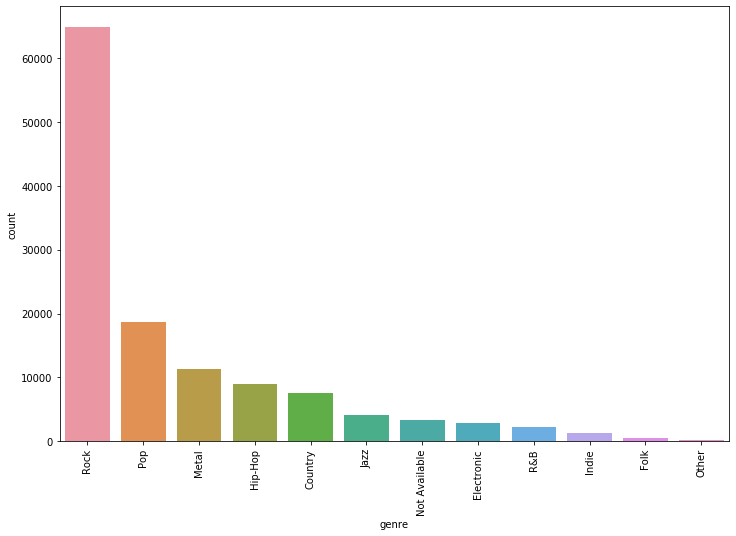

In [4]:
fig, axes = plt.subplots(1,1, figsize= (12,8))

sns.countplot(lyrics['genre'], order = lyrics['genre'].value_counts().index)
plt.xticks(rotation = 90);

Data span from the 1970s to the 2010s (decades '110', '700', and '1960' have been left out for analysis over decades as they are erroneous values and/or only contain single data point).

In [5]:
np.sort(lyrics['decade'].unique())

array([ 110,  700, 1960, 1970, 1980, 1990, 2000, 2010], dtype=int64)

In [6]:
lyrics.groupby(['decade','genre']).count()['song']

decade  genre        
110     Hip-Hop              1
700     Hip-Hop              1
1960    Rock                 1
1970    Country             49
        Electronic           9
        Folk                10
        Jazz                80
        Not Available       65
        Other                5
        Pop                163
        R&B                 65
        Rock               778
1980    Country             20
        Electronic          14
        Hip-Hop             11
        Jazz                92
        Metal               63
        Not Available       12
        Other               13
        Pop                210
        R&B                 67
        Rock               678
1990    Country            219
        Electronic          44
        Folk                27
        Hip-Hop            254
        Jazz               186
        Metal              184
        Not Available      149
        Other                5
        Pop                478
        R&B      

'Rock' is the most dominant over the whole time period but since 1990s, 'Pop' and 'Hip-Hop' has continued to grow while the proportion of 'Rock' has decreased.

In [7]:
genre_keys = ['Rock', 'Pop', 'Metal', 'Hip-Hop', 'Country','Jazz', 'Electronic','R&B','Indie','Folk']
decade_keys = [1970, 1980, 1990, 2000, 2010]

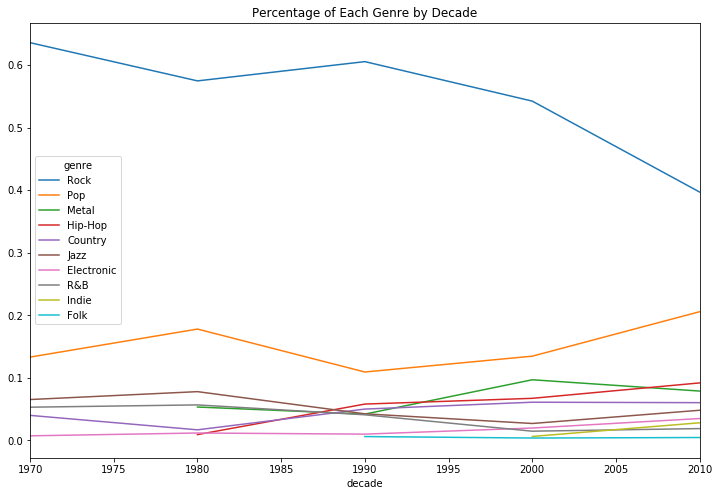

In [8]:
fig, axes = plt.subplots(1,1, figsize= (12,8))
genres_by_year = lyrics.groupby(['decade','genre']).count()['song'].drop([110,700,1960]) / lyrics.groupby(['decade'])['song'].count().drop([110,700,1960])
genres_by_year.unstack()[genre_keys].plot(ax = axes)
plt.title('Percentage of Each Genre by Decade');

In [9]:
genre_groups = lyrics.groupby(['genre'])
decade_groups = lyrics.groupby(['decade'])

## TF-IDF Scores
TF-IDF (Term Frequency - Inverse Document Frequency) is a statistic that reflects how important a word is to a document in a corpus.
### By Genre
It is notable that 'love' is a common topic over different genres. Meanwhile, 'Metal' and 'Hip-Hop' were the only two genres that the top features did not include 'love'. 'Metal' included words like 'life' and 'time' and 'Hip-Hop' was the only genre with a slang included in top features.

In [10]:
texts_genre = [' '.join(genre_groups.get_group(key)['stemmed lyrics'].tolist()) for key in genre_keys]

tfidf_vectorizer_genre = TfidfVectorizer(decode_error='ignore')
tfidf_matrix_genre = tfidf_vectorizer_genre.fit_transform(texts_genre)
   # The above line can take some time (about < 60 seconds)
feature_names_genre = tfidf_vectorizer_genre.get_feature_names()

In [11]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_idx, top_n=25):
    row = np.squeeze(X[row_idx].toarray())
    return top_tfidf_feats(row, features, top_n)

[ TF-IDF Scores by Genre ]


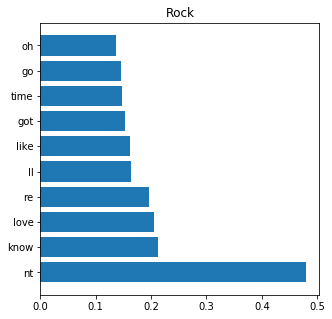

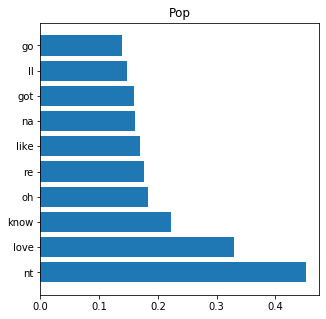

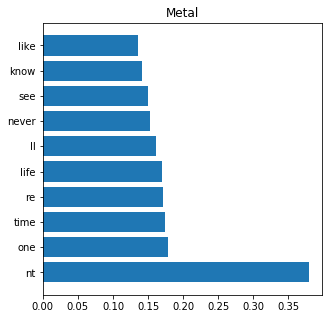

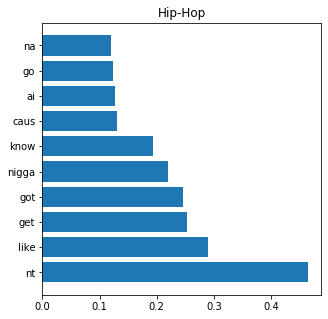

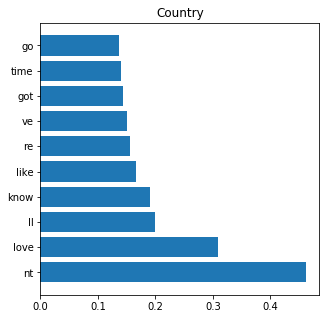

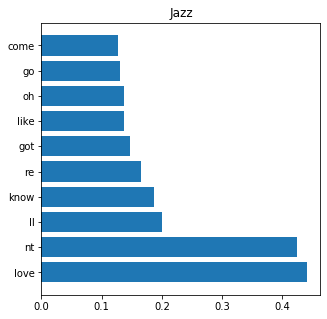

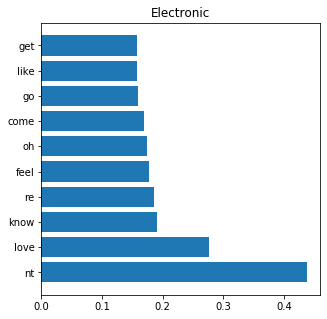

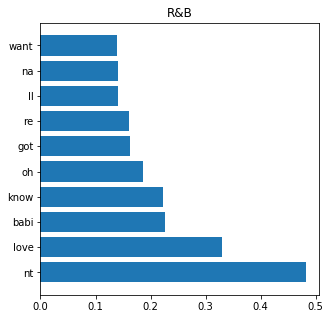

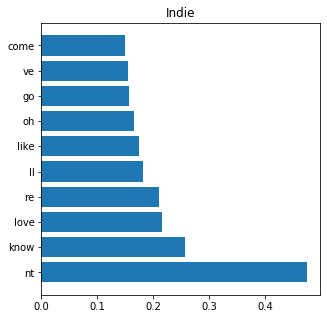

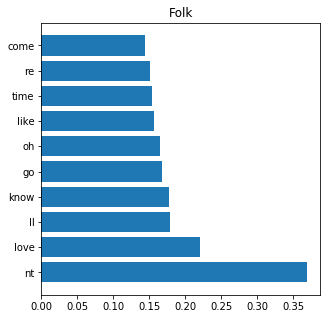

In [12]:
print("[ TF-IDF Scores by Genre ]")
for i in range(len(genre_keys)):
    plt.subplots(1,1, figsize = (5,5))
    top_feats_genre = top_feats_in_doc(tfidf_matrix_genre, feature_names_genre, i, 10)
    plt.barh(top_feats_genre['features'], top_feats_genre['score'])
    plt.title(genre_keys[i])

### By Decade
Top features in different decades were relatively more similar. As in scores by genre, 'love' was a popular word in all times.

In [13]:
texts_decade = [' '.join(decade_groups.get_group(key)['stemmed lyrics'].tolist()) for key in decade_keys]

tfidf_vectorizer_decade = TfidfVectorizer(decode_error='ignore')
tfidf_matrix_decade = tfidf_vectorizer_decade.fit_transform(texts_decade)
   # The above line can take some time (about < 60 seconds)
feature_names_decade = tfidf_vectorizer_decade.get_feature_names()

[ TF-IDF Scores by Decade ]


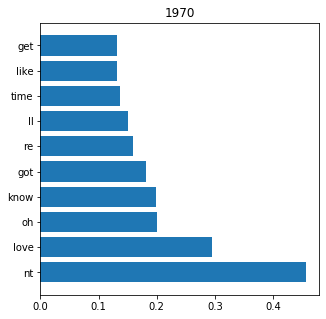

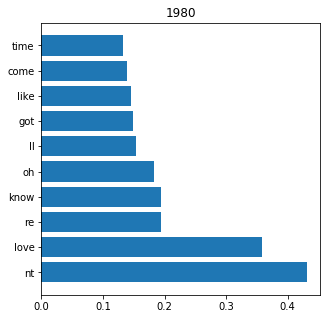

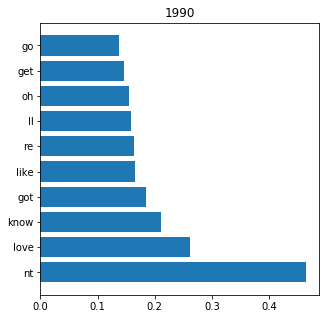

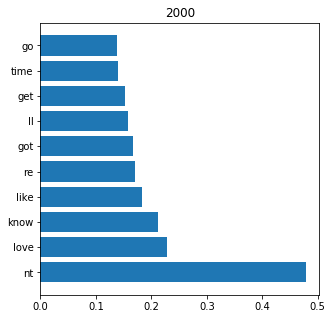

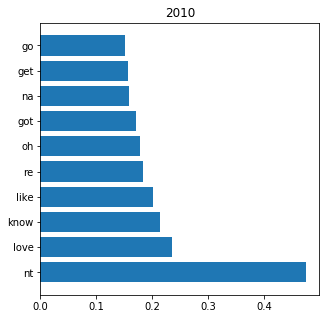

In [14]:
print("[ TF-IDF Scores by Decade ]")
for i in range(len(decade_keys)):
    plt.subplots(1,1, figsize = (5,5))
    top_feats_decade = top_feats_in_doc(tfidf_matrix_decade, feature_names_decade, i, 10)
    plt.barh(top_feats_decade['features'], top_feats_decade['score'])
    plt.title(decade_keys[i])

## Word Clouds
Word cloud shows most commonly used words in each genre/decade.
### By Genre
Again, 'love' was a popular word in most genres. An interesting observation on 'pop' is that it talks relatively less about 'love' compared to most other genres except 'Rock' and 'Hop-Hop'. Some notable words in 'Metal' genre include 'dream', 'life', 'dark', 'death', 'world', 'time', etc. It talks more about life in general and metaphysical concepts than other genres. In 'Hip-Hop' genre, there were significantly more slangs included in the word cloud.

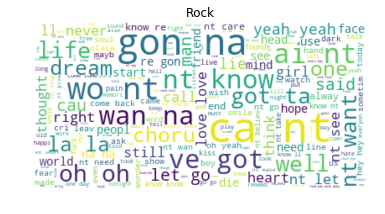

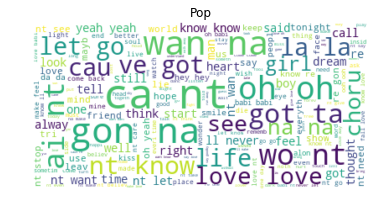

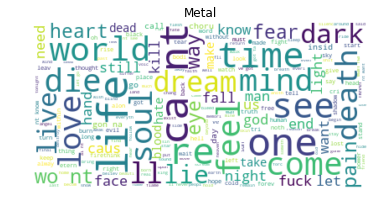

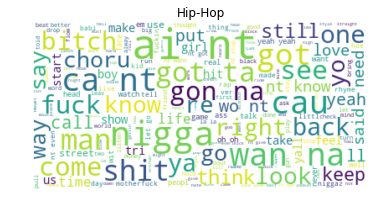

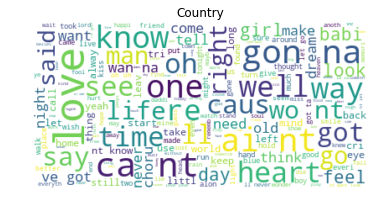

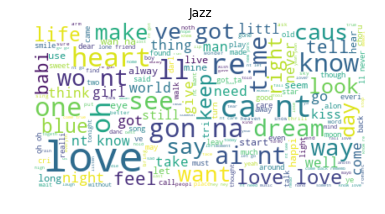

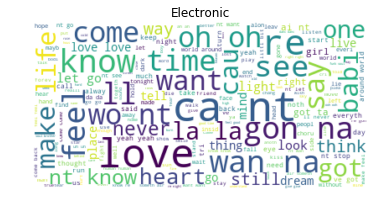

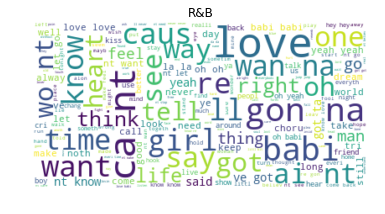

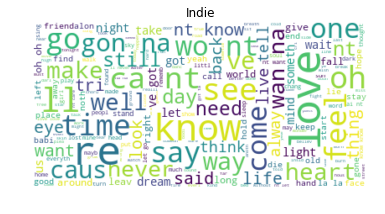

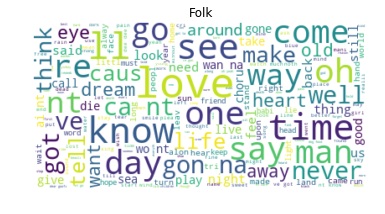

In [15]:
for key in genre_keys:
    genre = genre_groups.get_group(key)
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(' '.join(genre['stemmed lyrics'].tolist()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(key)
    plt.axis("off")
    plt.show()

### By Decade
The word clouds for different decades were relatively more similar over  time. Some popular words of all time include 'love', 'time', 'day', and 'know'.

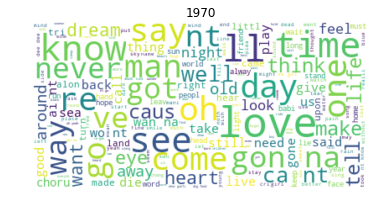

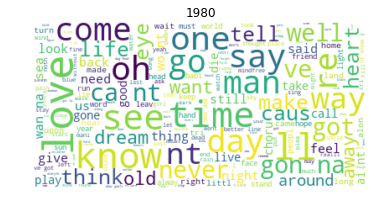

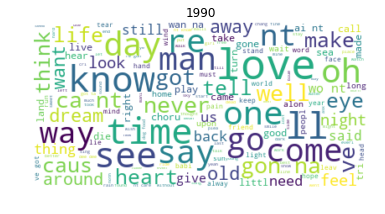

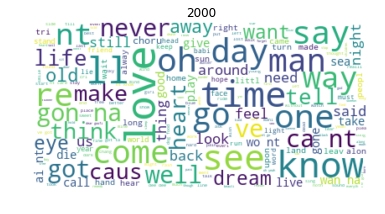

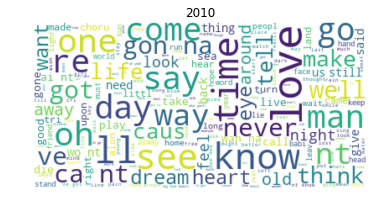

In [16]:
for key in decade_keys:
    decade = decade_groups.get_group(key)
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(' '.join(genre['stemmed lyrics'].tolist()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(key)
    plt.axis("off")
    plt.show()

## LDA Topic Modeling
LDA (Latent Dirichlet allocation) is a generative statistical model in natural language processing. It is a soft clustering method for text data. By LDA, sets of observations are explained by unobserved groups that explain similarity over parts of the data. That is, each document may be viewed as a mixture of various topics.
### By Genre
Some observations showed similar patterens as in the TF-IDF scores and word clouds. 'Love' was a popular topic among all genres, slangs were included in 'Hip-Hop', and many dark, metaphysical topics were inlucded in 'Metal'. There were also some additional interesting findings. 'Money' related topics were included in 'Pop' and 'Hip-Hop'. Another interesting observation is the way in which 'love' is described in different genres. While 'love' was a popular topic over all genres, some genres tended to talk more about 'love' and in different ways. For example, in genres like 'Country', 'Jazz' and 'Indie', the word 'love' was included in more than 4 topics out of 10. The way in which 'love' is described also seemed to differ between genres. For example, while 'love' was included in the same topic with words like 'fuck', 'never', 'noth', 'everyth' in 'Metal', in 'Country' it was included in the same topic with words like 'sweet', 'shile', 'heaven', and 'angel'.

In [19]:
for key in genre_keys:
    genre = genre_groups.get_group(key)
    texts = [nltk.word_tokenize(song) for song in genre['stemmed lyrics']]
    word_dictionary = corpora.Dictionary(texts)
    for idx, val in enumerate(word_dictionary): word_dictionary[idx]
    dt_matrix = [word_dictionary.doc2bow(text) for text in texts]  # Tuple (Term ID, Term Frequency)
    ldamodel = gensim.models.ldamodel.LdaModel(dt_matrix, num_topics=10, id2word=word_dictionary.id2token, passes=20)
    print("\n[ Genre: ",key," ]")
    pprint.pprint(ldamodel.print_topics())


[ Genre:  Rock  ]
[(0,
  '0.063*"go" + 0.059*"let" + 0.053*"s" + 0.027*"roll" + 0.027*"danc" + '
  '0.023*"rock" + 0.016*"like" + 0.013*"round" + 0.013*"move" + 0.012*"ride"'),
 (1,
  '0.028*"s" + 0.026*"girl" + 0.024*"man" + 0.023*"littl" + 0.017*"said" + '
  '0.016*"boy" + 0.014*"well" + 0.013*"like" + 0.012*"old" + 0.012*"good"'),
 (2,
  '0.102*"m" + 0.077*"got" + 0.039*"get" + 0.034*"come" + 0.033*"nt" + '
  '0.025*"back" + 0.024*"ve" + 0.019*"ai" + 0.017*"s" + 0.017*"ta"'),
 (3,
  '0.036*"live" + 0.033*"us" + 0.031*"world" + 0.029*"god" + 0.025*"die" + '
  '0.024*"life" + 0.017*"man" + 0.016*"peopl" + 0.015*"save" + 0.013*"one"'),
 (4,
  '0.055*"s" + 0.025*"get" + 0.019*"re" + 0.016*"got" + 0.016*"like" + '
  '0.015*"nt" + 0.007*"make" + 0.007*"one" + 0.006*"big" + 0.006*"money"'),
 (5,
  '0.126*"na" + 0.115*"oh" + 0.086*"yeah" + 0.079*"gon" + 0.042*"babi" + '
  '0.040*"hey" + 0.037*"wan" + 0.029*"re" + 0.019*"s" + 0.017*"ooh"'),
 (6,
  '0.151*"nt" + 0.074*"love" + 0.043*"want" +


[ Genre:  Electronic  ]
[(0,
  '0.066*"right" + 0.037*"soul" + 0.031*"bout" + 0.029*"funk" + '
  '0.028*"brother" + 0.021*"sleep" + 0.017*"re" + 0.015*"check" + 0.011*"lose" '
  '+ 0.011*"call"'),
 (1,
  '0.022*"la" + 0.022*"day" + 0.017*"could" + 0.016*"love" + 0.016*"never" + '
  '0.013*"littl" + 0.011*"like" + 0.010*"ll" + 0.010*"away" + 0.010*"life"'),
 (2,
  '0.043*"s" + 0.032*"oh" + 0.014*"night" + 0.009*"light" + 0.009*"time" + '
  '0.009*"ve" + 0.008*"place" + 0.008*"blue" + 0.008*"m" + 0.008*"take"'),
 (3,
  '0.033*"m" + 0.033*"s" + 0.027*"feel" + 0.027*"come" + 0.018*"re" + '
  '0.017*"need" + 0.017*"want" + 0.016*"love" + 0.015*"oh" + 0.015*"ll"'),
 (4,
  '0.063*"na" + 0.032*"wan" + 0.026*"gon" + 0.025*"world" + 0.024*"got" + '
  '0.020*"get" + 0.018*"danc" + 0.017*"m" + 0.017*"nt" + 0.015*"go"'),
 (5,
  '0.109*"nt" + 0.038*"go" + 0.035*"ca" + 0.032*"know" + 0.022*"s" + '
  '0.019*"re" + 0.019*"caus" + 0.018*"love" + 0.017*"heart" + 0.016*"let"'),
 (6,
  '0.039*"m" + 0.019*

### By Decade
As observed in the previous analysis, 'love' has been a popular topic over all times. While in 1980s there were 'love' included in notably more topics than in other decades, there were relatively less difference over time in the way in which 'love' is described compared to LDA modeling by Genre. What is interesting is that starting from 1980s, where data for 'Hip-Hop' was first included, one or more slang is included in the topics for every decade and the number of slangs increase as it gets closer to the 2010s. This reflects the growth of 'Hip-Hop' over decade visualized in the graph 'Percentage of Each Genre by Decade.'

In [20]:
for key in decade_keys:
    decade = decade_groups.get_group(key)
    texts = [nltk.word_tokenize(song) for song in decade['stemmed lyrics']]
    word_dictionary = corpora.Dictionary(texts)
    for idx, val in enumerate(word_dictionary): word_dictionary[idx]
    dt_matrix = [word_dictionary.doc2bow(text) for text in texts]  # Tuple (Term ID, Term Frequency)
    ldamodel = gensim.models.ldamodel.LdaModel(dt_matrix, num_topics=10, id2word=word_dictionary.id2token, passes=20)
    print("\n[ Decade: ",key," ]")
    pprint.pprint(ldamodel.print_topics())


[ Decade:  1970  ]
[(0,
  '0.019*"s" + 0.019*"peopl" + 0.015*"move" + 0.014*"yeah" + 0.013*"nt" + '
  '0.012*"never" + 0.010*"re" + 0.010*"back" + 0.010*"know" + 0.008*"oh"'),
 (1,
  '0.031*"nt" + 0.027*"s" + 0.023*"babi" + 0.021*"love" + 0.017*"know" + '
  '0.016*"go" + 0.016*"na" + 0.015*"time" + 0.014*"let" + 0.013*"come"'),
 (2,
  '0.036*"lord" + 0.030*"nt" + 0.016*"ca" + 0.015*"know" + 0.011*"babe" + '
  '0.011*"oh" + 0.009*"funki" + 0.009*"s" + 0.009*"m" + 0.008*"feel"'),
 (3,
  '0.024*"m" + 0.023*"ll" + 0.021*"s" + 0.018*"know" + 0.015*"nt" + '
  '0.015*"got" + 0.014*"oh" + 0.010*"ve" + 0.009*"day" + 0.009*"man"'),
 (4,
  '0.053*"nt" + 0.036*"s" + 0.027*"love" + 0.015*"get" + 0.013*"got" + '
  '0.012*"re" + 0.012*"ca" + 0.011*"want" + 0.010*"like" + 0.009*"time"'),
 (5,
  '0.026*"got" + 0.019*"s" + 0.016*"danc" + 0.012*"nt" + 0.011*"believ" + '
  '0.011*"m" + 0.011*"friend" + 0.009*"ta" + 0.008*"love" + 0.008*"see"'),
 (6,
  '0.021*"s" + 0.014*"one" + 0.013*"m" + 0.013*"take" +